#Machine Learning - Regressão Linear

O objetivo deste projeto é prever, utilizando um algoritmo de Regressão Linear, os custos de plano de saúde de novos clientes (variável **charges**, ou custos) com base em informações obtidas de clientes anteriores (variáveis **ibm**, ou IMC, e **smoker**, ou fumante)

Para fazer uma previsão ou classificação utilizando Machine Learning, são necessários os seguintes elementos:


*   Modelo: responsável por fazer a previsão da variável resposta com base nos dados das variáveis de entrada. Neste projeto: Regressão Linear
*   Método de Validação: procedimento realizado a fim de estimar o desempenho do modelo, limitando seu acesso a todos os dados para evitar o Overfitting. Assim, garante que o modelo tenha capacidade de acertar previsões feitas com base em dados novos. Neste projeto: Holdout
*   Métrica: valor que mensura o erro de previsão do modelo. Neste projeto: Erro Quadrático Médio



In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

##Overview: Conhecendo o Conjunto de Dados

Antes da análise exploratória dos dados, é preciso conhecer o conjunto de dados a ser manipulado. Isto é feito pela análise das variáveis e pela verificação de suas principais medidas descritivas

In [ ]:
url = 'https://raw.githubusercontent.com/ricardorocha86/Datasets/master/Custos%20M%C3%A9dicos/insurance.csv'

dados = pd.read_csv(url)

A análise das variáveis acontece quando identificamos seu nome e seu tipo, o que nos indica qual a informação que ela contém

In [ ]:
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Já as medidas descritivas nos mostram de forma resumida as principais características dos dados, nos indicando também como eles estão distribuídos. Podemos verificar dados faltantes comparando a contagem das variáveis com o número de linhas totais entregue pelo shape, a amplitude pelos valores mínimo e máximo, e ter uma ideia sobre a assimetria da distribuição pela diferença entre a média e a mediana

In [ ]:
dados.shape

(1338, 7)

In [ ]:
dados.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


##Análise Exploratória de Dados com SweetViz

Sweetviz é uma biblioteca que constrói de forma automática gráficos referentes a cada variável do conjunto, permitindo uma análise preliminar rápida dos dados

In [ ]:
!pip install Sweetviz

In [ ]:
import sweetviz

###Análise Univariada

In [ ]:
eda = sweetviz.analyze(dados)
eda.show_html(filepath = 'Relatorio_Univariado.html')

###Análise Bivariada

Colocando a variável charges como o alvo da análise, observamos como as demais variáveis impactam em seu valor 

In [ ]:
eda2 = sweetviz.analyze(dados, target_feat = 'charges')
eda2.show_html(filepath = 'Relatorio_Bivariado.html')

Como a análise bivariada mostrou a importância da variável **smoker** no valor de **charges**, comparamos o perfil de fumantes e não fumantes

In [ ]:
eda3 = sweetviz.compare_intra(dados, dados['smoker'] == 'yes', ['Fumante','Não Fumante'])
eda3.show_html(filepath = 'Relatorio_Bivariado1.html')

##Pré-Processamento dos Dados

Para fazermos uma boa previsão é preciso alimentar o modelo com dados de boa qualidade, ou seja, processados de modo a viabilizar ou otimizar sua utilização pelo algoritmo

Como o algoritmo de machine learning cria uma função matemática para fazer sua previsão, todas as variáveis a serem utilizadas precisam ser números. Neste caso, transformamos a variável **smoker** em binária, alocando 0 para no e 1 para yes

In [ ]:
dados['smoker'] = dados['smoker'].map({'yes':1, 'no':0})

Ao analisar os dados com describe, verificou-se que o desvio padrão de **charges** está muito alto, logo os dados estão muito dispersos. Diminuir seu intervalo ajuda a diminuir o erro quadrático médio e a interpretar melhor os dados. Por isso, a escala da variável foi alterada para cada mil dólares

In [ ]:
dados['charges'] = dados['charges']/1000

Selecionamos, por fim, quais as variáveis que vão compor nosso novo conjunto de dados

In [ ]:
dados = dados[['bmi', 'smoker', 'charges']]

##Gráficos Pertinentes

Ainda no contexto da análise dos dados, buscamos entender as relações entre as variáveis com o uso de gráficos

Gráfico de dispersão verificando a relação entre a variável **bmi** e a variável resposta **charges**

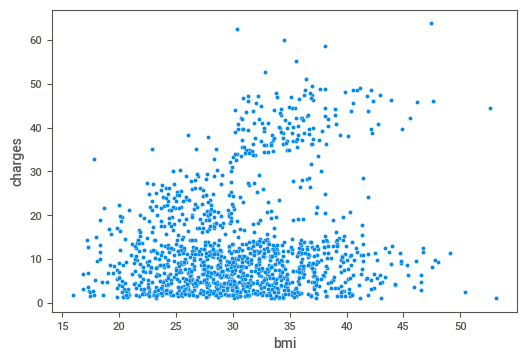

In [ ]:
sns.scatterplot(x = 'bmi', y = 'charges', data = dados);

Como a variável **smoker** foi identificada como importante para a alteração da variável resposta, refazemos o gráfico de dispersão acima a adicionando à análise

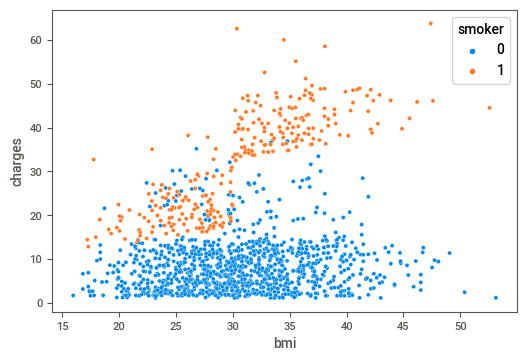

In [ ]:
sns.scatterplot(x = 'bmi', y = 'charges', hue = 'smoker', data = dados);

#Fazendo a Previsão

Para fazer a previsão desejada, o valor da variável **charges**, vamos considerar dois cenários distintos. No primeiro deles, utilizaremos apenas a variável **bmi**. Já no segundo, utilizaremos além de **bmi** a variável **smoker**, identificada durante a análise como pertinente para o valor de **charges**

##Cenário 1: Considerando Apenas a Variável **bmi**

O primeiro cenário a ser considerado é a previsão do custo a partir apenas da variável **bmi**

DEFINIÇÃO DE VARIÁVEIS

Definimos quais as variáveis explicativas X (neste cenário apenas **bmi**) serão usadas para encontrar a variável resposta y (neste projeto, **charges**)

In [ ]:
X = dados['bmi'].values.reshape(-1,1)
y = dados['charges']

AVALIAÇÂO DO MODELO

Uma vez definidas as variáveis, usamos o método de validação para avaliar o desempenho do modelo. Neste projeto, será utilizado o método de validação Holdout, que separa o conjunto de dados em dados de treino e dados de teste

In [ ]:
Xtreino, Xteste, ytreino, yteste = train_test_split(X, y, test_size = 0.25)

Os dados de treino são usados para ajustar o modelo de machine learning, que neste projeto é a Regressão Linear

In [ ]:
reg = LinearRegression()
reg.fit(Xtreino, ytreino)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Já os dados de teste são usados para avaliar os erros do modelo. Usando o X alocado para teste, usa-se o modelo ajustado para prever quais serão as variáveis resposta y correspondentes

In [ ]:
preditos = reg.predict(Xteste)

Depois, por meio da métrica, comparamos a previsão feita pelo do modelo aos valores reais que y assume. Neste projeto, usamos a métrica do Erro Quadrático Médio

In [ ]:
eqm = mean_squared_error(yteste, preditos)
print(f'EQM: {eqm:.2f}')

EQM: 150.35


REPRESENTAÇÃO GRÁFICA DO MODELO

Para traçar o gráfico do modelo, é preciso encontrar os coeficientes da função que modela a Regressão Linear: $$charges = B0 + B1*bmi$$

In [ ]:
b0 = reg.intercept_
b1 = reg.coef_

print('Intercepto:\n', b0)
print('Coeficientes:\n', b1)

Intercepto:
 0.9576695059508271
Coeficientes:
 [0.39489424]


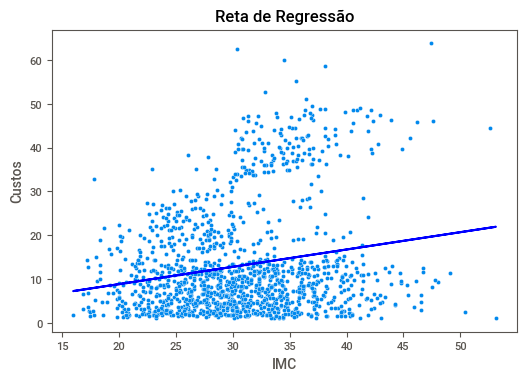

In [ ]:
x = np.arange(15, 55, 0.01)
y0 = b0+b1*X

sns.scatterplot(x = 'bmi', y = 'charges', data = dados);
plt.plot(X, y0, color = 'blue')
plt.title('Reta de Regressão')
plt.xlabel('IMC')
plt.ylabel('Custos')
plt.show()

## Cenário 2: Considerando as Variáveis **bmi** e **smoker**

Para o segundo cenário, que utiliza as variáveis **bmi** e **smoker** como variáveis explicativas para prever a variável resposta **charges**, são feitos os mesmos procedimentos do Cenário 1

DEFINIÇÃO DE VARIÁVEIS

In [ ]:
X = dados[['bmi', 'smoker']]
y = dados ['charges']

AVALIAÇÂO DO MODELO

In [ ]:
Xtreino, Xteste, ytreino, yteste = train_test_split(X, y, test_size = 0.25)

In [ ]:
reg = LinearRegression()
reg.fit(Xtreino, ytreino)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
preditos = reg.predict(Xteste)

In [ ]:
eqm = mean_squared_error(yteste, preditos)
print(f'EQM: {round(eqm,2)}')

EQM: 52.03


REPRESENTAÇÃO GRÁFICA DO MODELO

Função da Regressão Linear com duas variáveis explicativas: $$charges = B0 + B1*bmi + B2*smoker$$

In [ ]:
b0 = reg.intercept_
b1, b2 = reg.coef_

print(f'Intercepto:\n{reg.intercept_}')
print(f'Coeficientes:\n{reg.coef_}')

Intercepto:
-4.215553924158824
Coeficientes:
[ 0.41007902 23.63945324]


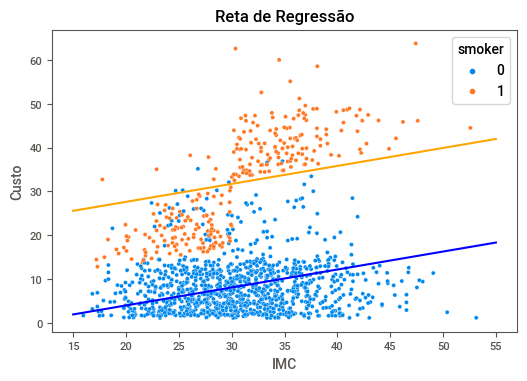

In [ ]:
x = np.arange(15, 55, 0.01)
y0 = b0 + b1*x + b2*0
y1 = b0 + b1*x + b2*1

sns.scatterplot(x = 'bmi', y = 'charges', hue = 'smoker', data = dados)
plt.plot(x, y0, color = 'blue')
plt.plot(x, y1, color = 'orange')
plt.title('Reta de Regressão')
plt.xlabel('IMC')
plt.ylabel('Custo')
plt.show()

#Considerações Finais

Concretizamos o objetivo de prever os custos de futuros clientes de seguro de duas formas: utilizando apenas uma variável (IMC) e duas variáveis distintas (IMC e fumantes). De acordo com a métrica escolhida, o Erro Quadrático Médio, foi possível observar que o Cenário 2 obteve um erro menor do que o Cenário 1, possuindo portanto melhor performance. Assim, verificamos que é possível melhorar a previsão feita pelo modelo adicionando a ele mais informações, desde que elas sejam relevantes